In [1]:
import numpy as np
import pandas as pd
from epiweeks import Week
import matplotlib.pyplot as plt
from mosqlient import get_predictions

import seaborn as sns
from itertools import product
import matplotlib.dates as mdates

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def get_cases(data, state):
    data_ = data.loc[data.uf == state]
    
    data_.loc[:, 'date']  = pd.to_datetime(data_.date)

    data_ = data_.rename(columns = {'date':'dates'})

    data_.set_index('dates', inplace = True)
    
    return data_

Fetch the predictions from the API: 

%%time
for model_id in [21, 22, 25,26, 27, 28, 29, 30]:

    list_of_preds = get_predictions(model_id = model_id)

    for idx in np.arange(0, len(list_of_preds)): 

        df = list_of_preds[idx].to_dataframe()
        state = df.adm_1.unique()[0]

        if state in ['AM', 'CE', 'GO', 'PR', 'MG']:
            year = pd.to_datetime(df.dates).dt.year.max()
            if model_id == 26:
                
                model_id_ = 25
            else:
                model_id_ = model_id
                
            df.to_csv(f'./predictions/preds_{model_id_}_{state}_{year}.csv.gz',index = False)


### Make the panel

In [53]:
data = pd.read_csv('data/dengue_uf.csv.gz')

data.head()

,uf,date,casos
0,AC,2010-01-03,869
1,AC,2010-01-10,1003
2,AC,2010-01-17,1010
3,AC,2010-01-24,1397
4,AC,2010-01-31,2000


In [54]:
data.date.min()

'2010-01-03'

In [55]:
data.date.max()

'2024-06-02'

In [48]:
Week(year, 23).startdate()

datetime.date(2024, 6, 2)

In [25]:
from matplotlib.lines import Line2D

In [32]:
custom_lines = [Line2D([0], [0], color='black', marker='s', linestyle='None', markersize=10)]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
model_ids = [21, 22, 25, 27, 28, 29, 30]

model_legend = ['Data', 'Dobby data', 'Global Health Resilience', 
                'GeoHealth', 'Ki-Dengu Peppa model 1', 'Ki-Dengu Peppa model 2',
               'DS_OKSTATE', 'BB-M']

for c in colors: 

    custom_lines.append(Line2D([0], [0], color=c, marker='s', linestyle='None', markersize=10))
    

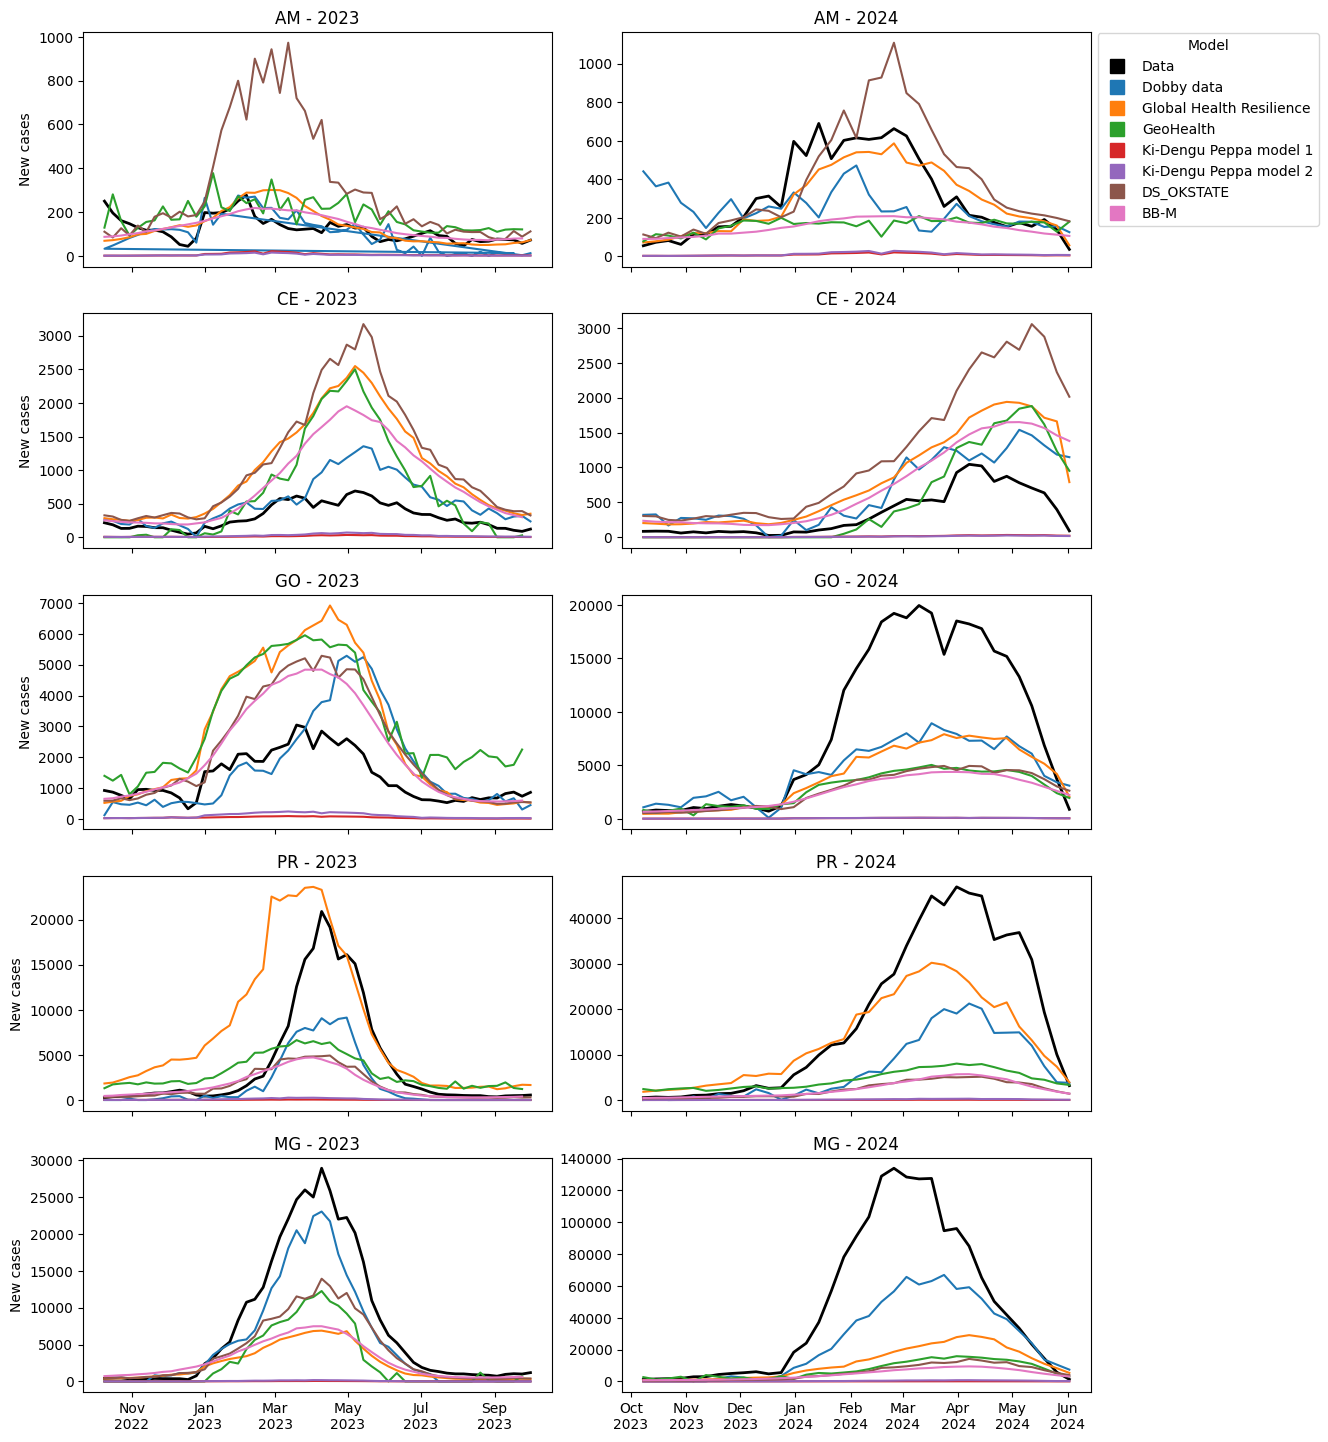

In [73]:
state = 'CE'
year = 2023

fig, axs  = plt.subplots(5,2, figsize = (13, 20))
    
ax =axs.ravel()
    
i = 0

for state,year in product(['AM','CE', 'GO', 'PR', 'MG'],
                    [2023, 2024]):
    start_date = Week(year-1, 41).startdate().strftime('%Y-%m-%d')

    if year==2024:
        end_date = '2024-06-02'
    else:
        end_date= Week(year, 40).startdate().strftime('%Y-%m-%d')
    data_ = get_cases(data, state)
    data_ = data_.loc[(data_.index >= pd.to_datetime(start_date)) & (data_.index <= pd.to_datetime(end_date))]
    
    ax[i].plot(data_.casos, color = 'black', label = 'Data', linewidth = 2)
    
    for model_id, color in zip(model_ids,
                               colors):
    
        preds = pd.read_csv(f'./predictions/preds_{model_id}_{state}_{year}.csv.gz')
        preds.dates = pd.to_datetime(preds.dates)
        preds.set_index('dates', inplace = True)
        preds = preds.loc[(preds.index >= pd.to_datetime(start_date)) & (preds.index <= pd.to_datetime(end_date))]
        
        ax[i].plot(preds.preds, color = color)
    
        #ax[i].fill_between(preds.index, preds.lower, preds.upper, color = color, alpha = 0.1)

    
    ax[i].set_title(f'{state} - {year}')

    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format as 'Jan 22'
    
    # Rotate the date labels for better readability
    fig.autofmt_xdate(rotation=0, ha='center')

    if year == 2023:
        ax[i].set_ylabel('New cases')

    i= i+1

ax[1].legend(custom_lines, model_legend, title ='Model', bbox_to_anchor=(1, 0.525, 0.1, 0.5))

plt.subplots_adjust(wspace = 0.15,)

plt.savefig(f'figures/comp_preds.png', dpi = 600, bbox_inches = 'tight')
plt.show()

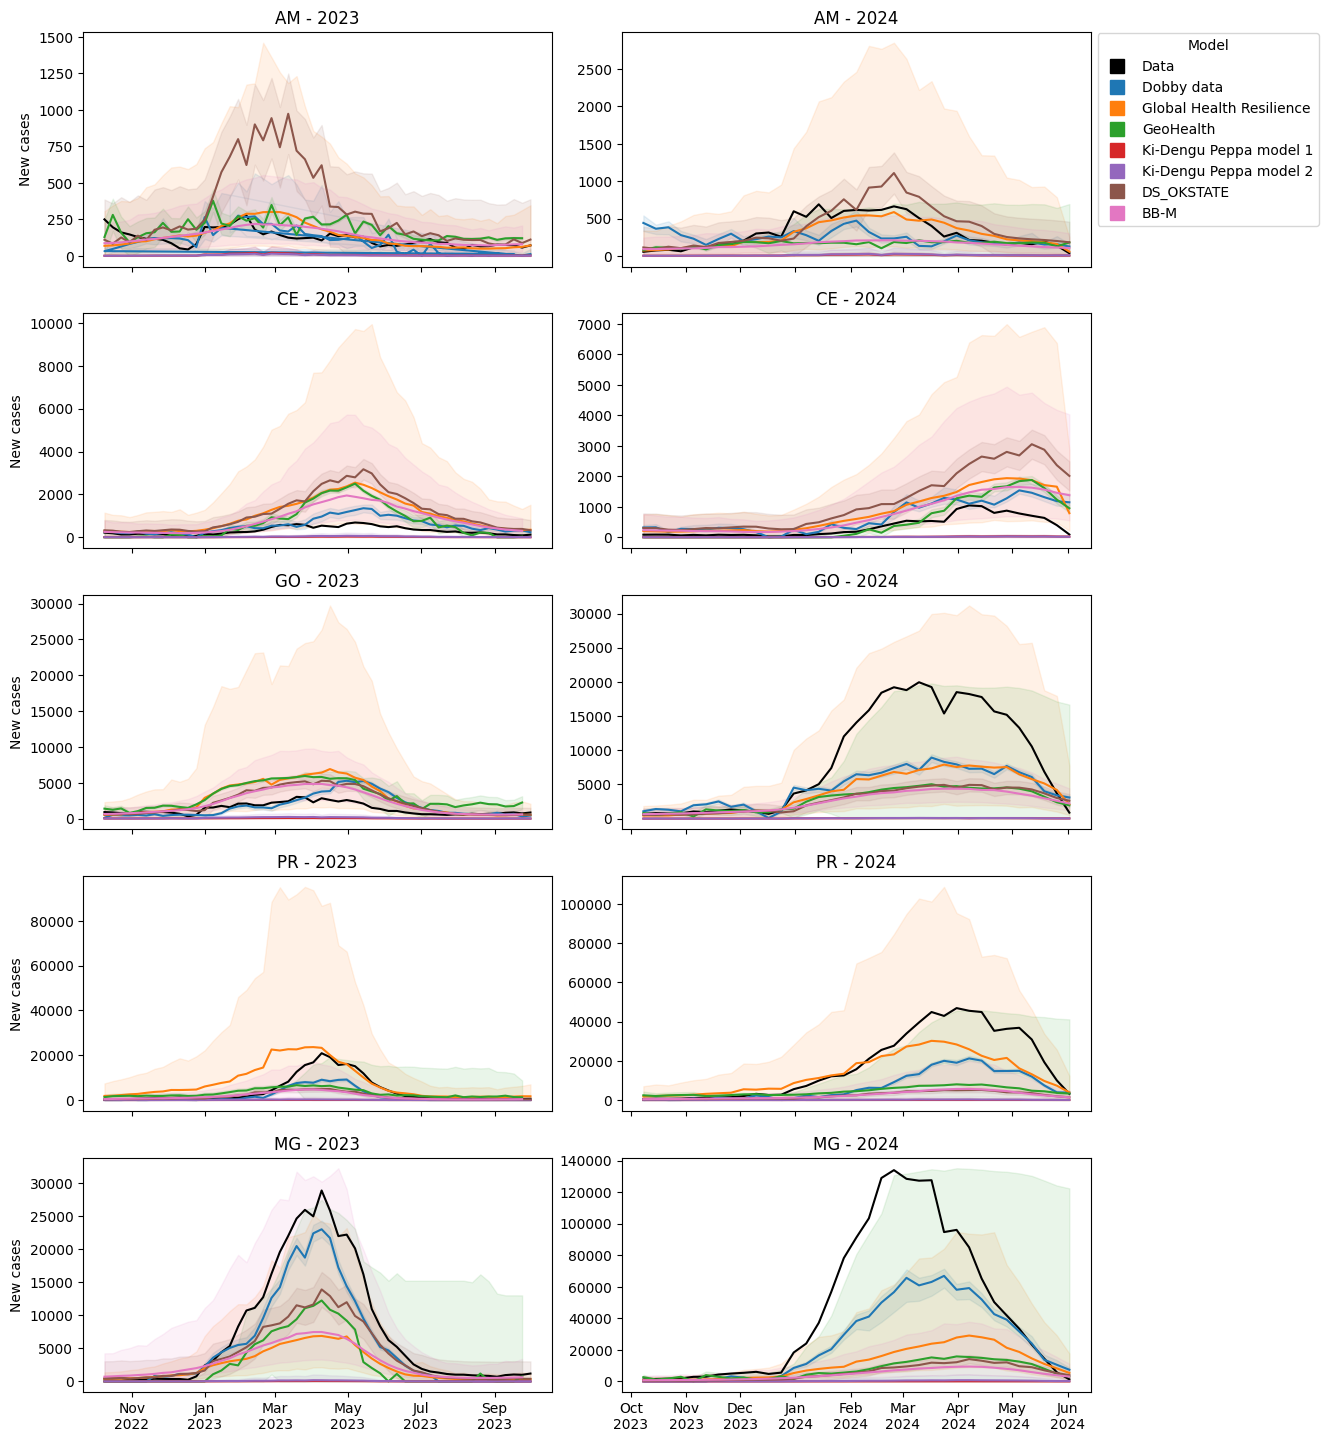

In [71]:
state = 'CE'
year = 2023

fig, axs  = plt.subplots(5,2, figsize = (13, 20))
    
ax =axs.ravel()
    
i = 0

for state,year in product(['AM','CE', 'GO', 'PR', 'MG'],
                    [2023, 2024]):
    start_date = Week(year-1, 41).startdate().strftime('%Y-%m-%d')

    if year==2024:
        end_date = '2024-06-02'
    else:
        end_date= Week(year, 40).startdate().strftime('%Y-%m-%d')
    data_ = get_cases(data, state)
    data_ = data_.loc[(data_.index >= pd.to_datetime(start_date)) & (data_.index <= pd.to_datetime(end_date))]
    
    ax[i].plot(data_.casos, color = 'black', label = 'Data')
    
    for model_id, color in zip(model_ids,
                               colors):
    
        preds = pd.read_csv(f'./predictions/preds_{model_id}_{state}_{year}.csv.gz')
        preds.dates = pd.to_datetime(preds.dates)
        preds.set_index('dates', inplace = True)
        preds = preds.loc[(preds.index >= pd.to_datetime(start_date)) & (preds.index <= pd.to_datetime(end_date))]
        
        ax[i].plot(preds.preds, color = color)
    
        ax[i].fill_between(preds.index, preds.lower, preds.upper, color = color, alpha = 0.1)

    
    ax[i].set_title(f'{state} - {year}')

    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format as 'Jan 22'
    
    # Rotate the date labels for better readability
    fig.autofmt_xdate(rotation=0, ha='center')

    if year == 2023:
        ax[i].set_ylabel('New cases')

    i= i+1

ax[1].legend(custom_lines, model_legend, title ='Model', bbox_to_anchor=(1, 0.525, 0.1, 0.5))

plt.subplots_adjust(wspace = 0.15,)

plt.savefig(f'figures/comp_preds_ci.png', dpi = 600, bbox_inches = 'tight')
plt.show()